## Predict the tag for a Stack Overflow question

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import pathlib
import tensorflow_text as tf_text
import tensorflow_datasets as tfdf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils

In [3]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin = data_url,
    untar = True,
    cache_dir = 'stack_overflow',
    cache_subdir = ''
)

dataset_dir = pathlib.Path(dataset_dir).parent
list(dataset_dir.iterdir())

6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


[PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/train'),
 PosixPath('/tmp/.keras/README.md')]

In [4]:
train_dir = dataset_dir / 'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/python')]

In [6]:
sample_file = train_dir / 'python/1755.txt'
with open(sample_file) as f:
    print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



In [7]:
# load the dataset
batch_size = 32
seed = 42

train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [8]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Question: {text_batch.numpy()[i]}')
        print(f'Label: {label_batch.numpy()[i]}')

Question: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default cons

In [10]:
for i, label in enumerate(train_ds.class_names):
    print(f'Label {i}: correspond to {label}')

Label 0: correspond to csharp
Label 1: correspond to java
Label 2: correspond to javascript
Label 3: correspond to python


In [11]:
# create the validation dataset
val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [12]:
# load the test_data
test_dir = dataset_dir / 'test'

test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size = batch_size,
    seed = seed
)

Found 8000 files belonging to 4 classes.


In [13]:
# configure dataset for performance

train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

## we will build 2 models to learn more about standardization, tokenization, and bag-of-words model:

1. first, you will use the `binary` vectorization mode to build a bag-of-words-model.
2. then, you will use the `int` mode with the 1D ConvNet

In [14]:
vocab_size = 10000
binary_vectorize_layer = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'binary'
)

for the `int` mode, in addition to max vocav size, you need to set an explicit maximum sequence length which will cause the layer to pad or truncate sequences to exactly output_sequence_lenght

In [17]:
max_len = 250
int_vectorize_layer = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = max_len
)

we will call `adapt` to fit the state of the preprocessing layer to the dataset. This Will cause the model to build an index of strings to integers.

In [18]:
train_text = train_ds.map(lambda text, label: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [19]:
text_batch, label_batch = next(iter(train_ds))
first_q, first_label = text_batch[0], label_batch[0]
print(f'Question: {first_q.numpy()}')
print(f'Label: {first_label.numpy()}')

Question: b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public static

binary vectorization [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

(0.0, 1000.0)

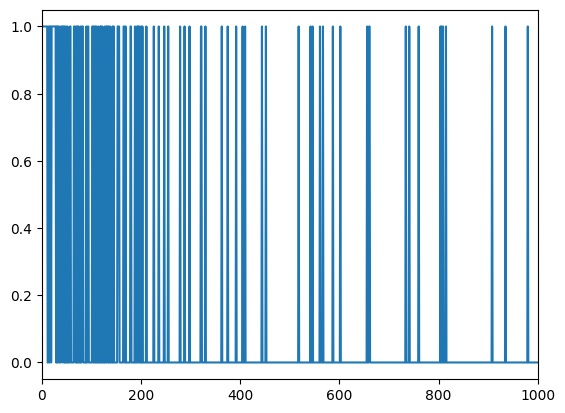

In [21]:
print('binary vectorization', list(binary_vectorize_layer(first_q).numpy()))

plt.plot(binary_vectorize_layer(first_q).numpy())
plt.xlim(0, 1000)

In [22]:
print('int_vectorization', list(int_vectorize_layer(first_q).numpy()))

int_vectorization [1, 111, 6, 23, 299, 1787, 198, 2, 3623, 299, 7826, 1, 1, 805, 2568, 23, 1, 1218, 3892, 364, 4145, 1, 1, 661, 16, 5, 981, 45, 121, 1881, 47, 1, 742, 36, 9987, 8, 1982, 322, 662, 36, 23, 2362, 195, 543, 83, 2693, 2609, 661, 144, 1, 411, 2, 1371, 23, 657, 1, 6520, 84, 66, 3, 166, 104, 26, 1182, 6, 5, 1, 1639, 44, 3, 189, 3623, 519, 1135, 1, 44, 5468, 280, 1272, 71, 156, 157, 5, 1759, 9, 331, 3, 227, 2, 3623, 299, 115, 810, 5, 547, 3833, 3, 1, 2371, 146, 202, 1195, 289, 1, 6, 2179, 1787, 193, 9, 136, 1195, 45, 6, 67, 181, 4, 11, 198, 106, 1, 1, 299, 31, 1, 2216, 1924, 29, 299, 53, 28, 2081, 22, 53, 42, 170, 154, 256, 7, 15, 453, 28, 1, 237, 2698, 1, 134, 2698, 131, 2698, 323, 2698, 1, 1, 1, 1, 1, 1, 23, 1, 2216, 1924, 29, 299, 22, 53, 42, 170, 154, 256, 1360, 15, 453, 28, 237, 1, 237, 68, 9, 196, 807, 28, 7167, 1, 237, 1, 1364, 1, 562, 1, 4406, 735, 1820, 761, 12, 28, 3, 19, 1, 3, 123, 12, 73, 196, 807, 28, 1, 1, 139, 94, 24, 406, 1, 35, 33, 5921, 1, 75, 128, 12, 2, 196,

In [25]:
# train the model

binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)
]
)
binary_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)
binary_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 10000)               │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
history_1 = binary_model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 59s 287ms/step - accuracy: 0.5252 - loss: 1.2403 - val_accuracy: 0.7769 - val_loss: 0.9149
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 285ms/step - accuracy: 0.8178 - loss: 0.8200 - val_accuracy: 0.7962 - val_loss: 0.7512
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 348ms/step - accuracy: 0.8612 - loss: 0.6523 - val_accuracy: 0.8094 - val_loss: 0.6654
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - accuracy: 0.8859 - loss: 0.5525 - val_accuracy: 0.8250 - val_loss: 0.6119
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - accuracy: 0.9012 - loss: 0.4833 - val_accuracy: 0.8300 - val_loss: 0.5752
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 84s 297ms/step - accuracy: 0.9146 - loss: 0.4311 - val_accuracy: 0.8325 - val_loss: 0.5485
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 338ms/step - accuracy: 0.9260 - loss: 0.3897 - val_accuracy: 0.8394 - val_loss: 0.5284
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.9338 - loss: 0

In [30]:
# int model
int_model = tf.keras.Sequential([
    layers.Input(shape = (1,), dtype = tf.string),
    int_vectorize_layer,
    layers.Embedding(vocab_size + 1, 64, mask_zero = True),
    layers.Dropout(0.5),
    layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'valid', strides = 2),
    layers.GlobalMaxPooling1D(),
    layers.Dense(4)
]
)
int_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)
int_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, 250)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 250, 64)             │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 124, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,372 (2.47 MB)

 Trainable params: 646,372 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history_2 = int_model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.3353 - loss: 1.3514 - val_accuracy: 0.5913 - val_loss: 1.0240
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6023 - loss: 0.9511 - val_accuracy: 0.7113 - val_loss: 0.7097
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7235 - loss: 0.7000 - val_accuracy: 0.7600 - val_loss: 0.6125
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7950 - loss: 0.5600 - val_accuracy: 0.7894 - val_loss: 0.5548
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8521 - loss: 0.4436 - val_accuracy: 0.7956 - val_loss: 0.5290
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8862 - loss: 0.3509 - val_accuracy: 0.8069 - val_loss: 0.5249
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9167 - loss: 0.2768 - val_accuracy: 0.8056 - val_loss: 0.5273
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9315 - loss: 0.2259 - val_accuracy: 0.8

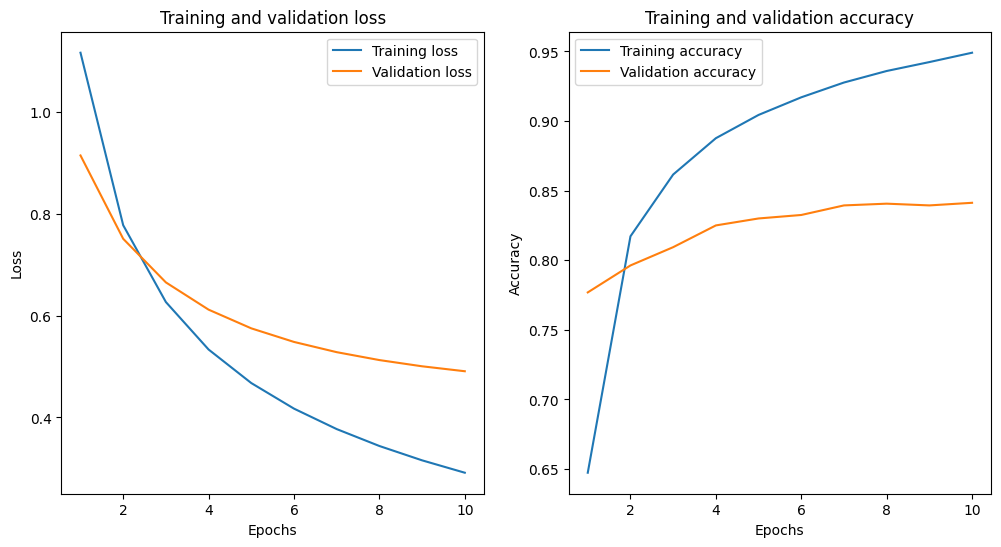

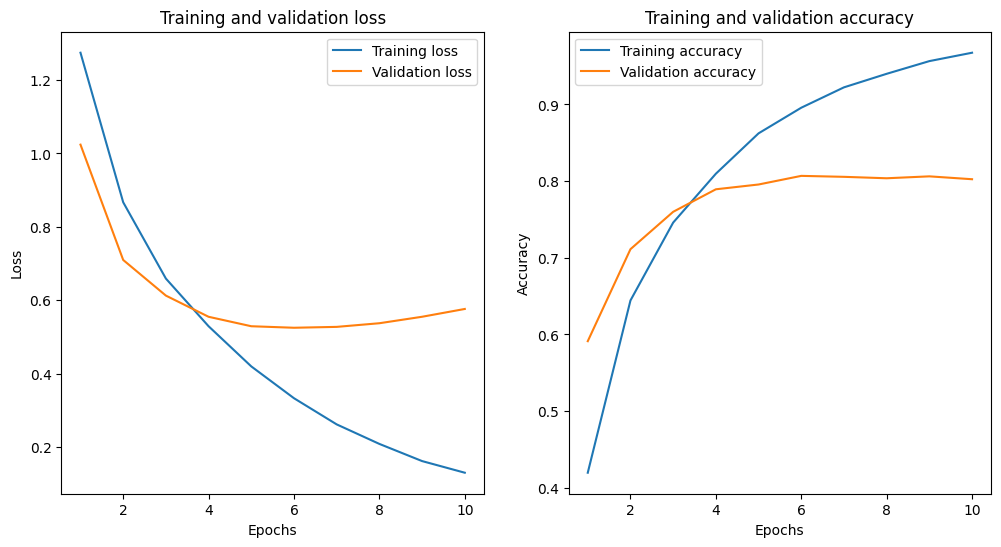

In [32]:
# plot the history of the models to compare between them
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label = 'Training accuracy')
    plt.plot(epochs, val_acc, label = 'Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_1)
plot_history(history_2)

In [33]:
binary_model.evaluate(test_ds)

250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 221ms/step - accuracy: 0.8128 - loss: 0.5203


[0.5173403024673462, 0.815750002861023]

In [34]:
binary_model.export('binary.tf')

Saved artifact at 'binary.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137594464295520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137594464297632: TensorSpec(shape=(), dtype=tf.int64, name=None)
  137594471540768: TensorSpec(shape=(), dtype=tf.string, name=None)
  137594471541120: TensorSpec(shape=(), dtype=tf.int64, name=None)
  137594222535680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137594471394016: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [36]:
loaded = tf.saved_model.load('binary.tf')

In [45]:
class_names = ['','cpp', 'java', 'python', 'js']
class_names[np.argmax(loaded.serve(tf.constant(['How do you sort a list?'])).numpy())]

'python'